In [1]:
from function.function import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from pandas.core import datetools
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')
get_ipython().magic('matplotlib inline')

/Users/sunghwanki/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1.EDA

### 1-1 데이터 소개

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

### 1-3  Analysis the univariance

In [3]:
train["MSSubClass"] = train["MSSubClass"].astype('str')

In [4]:
categorical_columns = ["ExterQual", "ExterCond","BsmtQual", "BsmtCond","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","FireplaceQu","GarageQual","GarageCond","PoolQC"]

for c in categorical_columns:
    train[c][(train[c] == "Ex") | (train[c] == "GLQ")] = 10
    train[c][(train[c] == "Gd") | (train[c] == "ALQ")] = 8
    train[c][(train[c] == "TA") | (train[c] == "BLQ")] = 6
    train[c][(train[c] == "Fa") | (train[c] == "Rec")] = 4
    train[c][(train[c] == "Po") | (train[c] == "LwQ")] = 2
    train[c][(train[c] == "NA") | (train[c] == "NaN") |(train[c] == "Unf")] = 0
    train[c] = train[c].astype('float')

In [5]:
# Categoric and Numerical 변수 분리
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [6]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

Numerical Features Qty : 49 

Numerical Features :  ['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 


Categorical Features Qty : 32 

Categorical Features : ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',

#### Numerical Features with SalePrice

## 2. Feature Engineering

### 2-1 SalePrice와 변수들 간의 관계 및 이상치 제거

#### 2-1-1 GrLivArea  &  2ndFloor & Basement

In [7]:
outlier_GrLivArea = train[(train["GrLivArea"] >4000)]
outlier_GrLivArea

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,10.0,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,8.0,NaN,NaN,0,1,2008,New,Partial,160000


In [8]:
train.drop(outlier_GrLivArea.index, axis=0,inplace=True)

Find : 1. Grliv 넓이가 중간 아래부분까지는 같은 넓이의 집은 2층보다 1층집의 값 더 비싼것을 알수 있었다
       2. 베이스먼트가 없는집은 거의 없으며, 집값에는 영향이 없는것 같다 

#### 2-1-2 OverallQual & OverallCond

In [9]:
outlier_OverallQual = train[(train["SalePrice"] >600000) | ((train["SalePrice"] > 500000) & (train["OverallQual"]==9)) | \
      ((train["SalePrice"] > 500000) & ((train["OverallQual"]==9) |(train["OverallQual"]==8)))]
outlier_OverallQual

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000


In [10]:
train.drop(outlier_OverallQual.index, axis=0, inplace=True)

Find : 1. 품질과 집값은 선형관계를 발견할 수 있으나 overall condition과 집값은 관계가 없는것을 발견할 수 있었음

#### 2-1-2 GarageArea & GarageCars

In [11]:
outlier_GarageArea = train[(train["SalePrice"] >500000)]
outlier_GarageArea

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


In [12]:
train.drop(outlier_GarageArea.index, axis=0,inplace=True)

Find :

#### 2-1-3 Neighborhood

In [13]:
df_train = train.copy()

# High_price_neighbor : 판매가 250000 이상 
# Middle_price_neighbor : 판매가 150000 ~ 250000
# Low_price_neighbor : 판매가 150000 이하
def neighbor_level(x):
    High_price_neighbor = ['NoRidge','NridgHt','StoneBr'] 
    Middle_price_neighbor = ['Timber','Somerst','Veenker','ClearCr','Crawfor','NWAmes', 'Gilbert','Blmngtn', 'SWISU','Mitchel','CollgCr']
    Low_price_neighbor = ['IDOTRR','Blueste', 'Sawyer','NAmes', 'BrDale', 'OldTown','MeadowV', 'NPkVill','BrkSide','Edwards']
    
    if str(x) in High_price_neighbor:
        return "high"
    elif str(x) in Middle_price_neighbor:
        return "middle"
    elif str(x) in Low_price_neighbor:
        return "low"

In [14]:
df_train["neighbor_level"] = df_train["Neighborhood"].apply(neighbor_level)
# l = df_train.groupby("neighbor_level").agg('mean')
# l = l.reindex(["high",'middle',"low"])

Find:


#### 2-1-4 YearBuilt

Find

1. 1950년대 이후로 지어진 집부터는 대체로 최근에 지어진 집의 가격이 높음을 알 수 있음.
2. 아직 리모델링이 되지 않은 집은 지어진 년도와 같은 년도로 기록되어 있음.
3. 리모델링은 1950년도 이후에 시행되었으며 오래된 집들은 대부분 1950년도에 리모델링 되었다고 기록되어 있음.
4. 매매년도는 2006년부터 2010년까지의 기록으로 되어있으며, 매매가 가장 많았던 년도는 2009년임.
5. OverallQual이 8-10인 집은 대체로 1980년도 이후에 지어진 집임.
6. 날이 따뜻한 5, 6, 7월에 가장 매매가 활발하게 이루어짐.

#### 2-1-5 Fireplaces & FireplaceQu

Find

1. FirePlaces가 0개인 집과 1개인 집의 가격 차이가 있음을 볼 수 있음.
2. FireplaceQu와 OverallQual은 밀접한 관계가 있음.
3. FireplaceQu는 SalePrice에 많은 영향을 미친다고 볼 수는 없음.
4. 같은 GrLivArea임에도 Fireplaces의 갯수는 차이가 있음.

#### 2-1-6 BsmtBath

BsmtFullBath : 지하실 가득한 욕실  
BsmtHalfBath : 지하 욕실 반 화장실

BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',

Find:

BsmtFUllBATH의 경우에는 최소값에 영향을 주고 & HalfBath 의 경우에는 salprice에 큰 영향을 주지 않는 것으로 보인다.

#### 2-1-7 TotRm and Bedroom

Find: 

확실히 TotRmsAbvGrd 는 연관관계가 있는것으로 보임

Tot : 길게 하나 하고, 어떤 방이 여기에 포함되어있는지 확인필요

이런 데이터의 경우에는 확실히 한단계 데이터 조치가 필요할것으로 보임
이런 경우는 어떻게 해야하지?

Full Bath의 경우에는 영향이 있으나 HalfBath의 경우에는 영향이 미미한것으로 확인할 수 있음

### 2-2 Missing Data 처리

3가지 정도의 가설

1. 미싱데이터 80% 이상의 데이터들을 제거했을때
2. 비어있는 값들의 처리를 0 or mean 값으로 한경우
3. one-hot encoding 했을때

In [15]:
ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)
print("All data size is {}".format(all_data.shape))

All data size is (2908, 81)


방법 2

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning']= all_data["MSZoning"].fillna(all_data['MSZoning'].mode()[0])

all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])

all_data['Functional']= all_data["Functional"].fillna("Typ")

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_data["Electrical"] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data["KitchenQual"]=all_data["KitchenQual"].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

all_data = all_data.drop(['Id'], axis=1) # Id 제거

In [17]:
train = all_data[:ntrain]
test = all_data[ntrain:]
y_train = train.SalePrice.values
all_data.drop(['SalePrice'], axis=1, inplace=True)

### 2-3 아웃라이어 제거

##### OLS 를 사용하여 아웃라이어 제거

In [18]:
all_data_dummy = pd.get_dummies(all_data)

In [19]:
all_data_dummy.drop(["SalePrice"], axis=1, inplace=True) 

In [20]:
x_train_x0 = all_data_dummy[:ntrain]

x_train = sm.add_constant(x_train_x0)
x_columns = x_train.columns

x_train1 = np.array(x_train)
y_train1 = np.array(y_train)

In [21]:
#OLS 모델 사용
model = sm.OLS(pd.DataFrame(y_train1, columns=["SalePrice"]),pd.DataFrame(x_train1,columns=x_columns))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     80.01
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        09:11:23   Log-Likelihood:                -16140.
No. Observations:                1449   AIC:                         3.281e+04
Df Residuals:                    1186   BIC:                         3.419e+04
Df Model:                         262                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   2.55e+

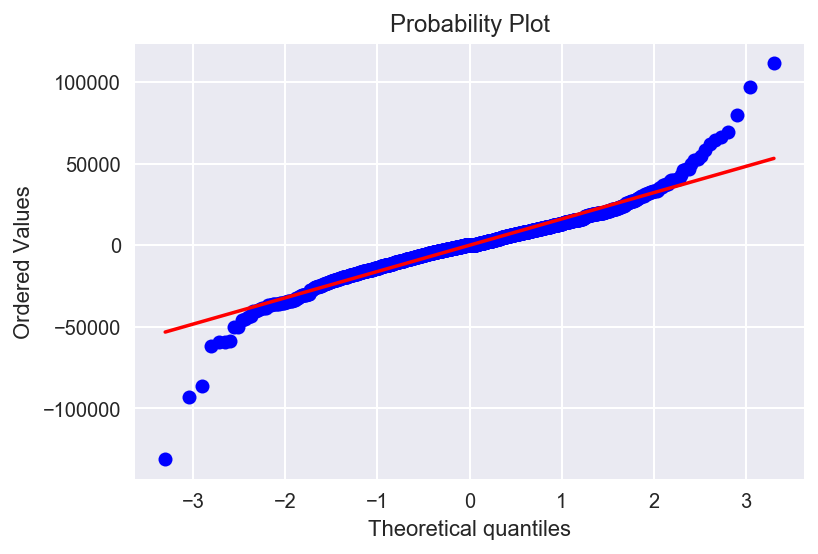

Chi^2       : 211.443
P-value     :  0.000


In [22]:
#잔차 정규성 확인
sp.stats.probplot(result.resid, plot=plt)
plt.show()

#Chi^2 확인
test_chi = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test_chi):
    print("%-12s: %6.3f" % xi)

In [23]:
# 아웃라이어 제거
idx = result.resid_pearson < 2

train = train[idx]

## 3. 변수선정 

### 3-1 numerical feature

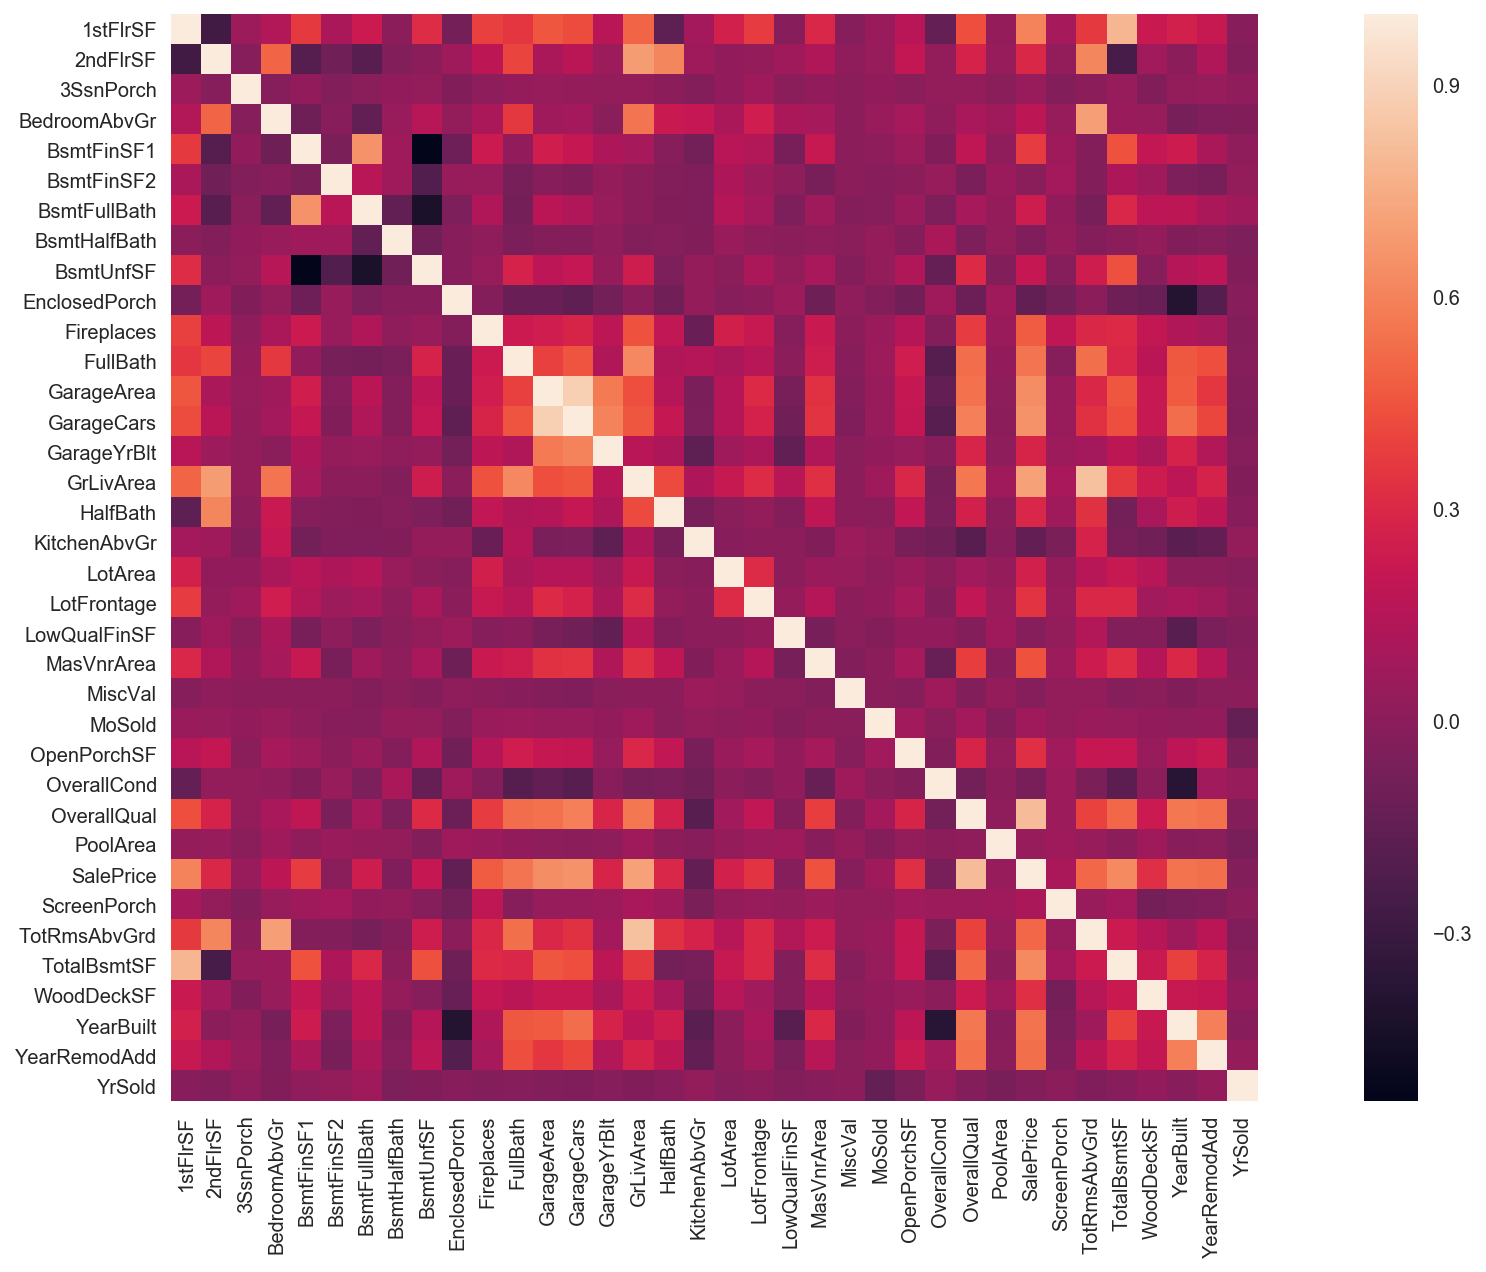

In [24]:
corrmat = train.corr()

f, ax = plt.subplots(figsize = (19,10))
sns.heatmap(corrmat, vmax =1, square = True)

In [95]:
k = 15

cor_numerical_cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index 
cor_numerical_cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd',
       'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1',
       'LotFrontage'],
      dtype='object')

In [96]:
train_nc = train[cor_numerical_cols]
train_nc.drop("SalePrice", axis=1, inplace=True)   
train_nc.tail()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,Fireplaces,MasVnrArea,BsmtFinSF1,LotFrontage
1444,6,1647,2.0,460.0,953.0,953,2,1999,2000,7,1,0.0,0.0,62.0
1445,6,2073,2.0,500.0,1542.0,2073,2,1978,1988,7,2,119.0,790.0,85.0
1446,7,2340,1.0,252.0,1152.0,1188,2,1941,2006,9,2,0.0,275.0,66.0
1447,5,1078,1.0,240.0,1078.0,1078,1,1950,1996,5,0,0.0,49.0,68.0
1448,5,1256,1.0,276.0,1256.0,1256,1,1965,1965,6,0,0.0,830.0,75.0


In [97]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_nc.values, i) for i in range(train_nc.values.shape[1])]
vif["features"] = train_nc.columns
vif.sort_values("VIF Factor", ascending=True)

,VIF Factor,features
11,1.702608,MasVnrArea
10,2.657965,Fireplaces
12,2.789726,BsmtFinSF1
13,14.879074,LotFrontage
6,18.211395,FullBath
4,25.521934,TotalBsmtSF
3,30.347938,GarageArea
2,35.065976,GarageCars
5,36.939326,1stFlrSF
0,49.598049,OverallQual


In [98]:
train_nc.drop(["YearRemodAdd","YearBuilt"], axis=1, inplace=True)   

### 3-2 Categorical features

In [99]:
train_cat = train[categorical_features]
y_train_d = train['SalePrice']

train_cat = pd.concat([y_train_d, train_cat], axis=1)
train_cat.tail()

,SalePrice,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,CentralAir,Electrical,Functional,GarageType,GarageFinish,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
1444,175000.0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,SBrkr,Typ,Attchd,RFn,Y,NaN,NaN,WD,Normal
1445,210000.0,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,SBrkr,Min1,Attchd,Unf,Y,MnPrv,NaN,WD,Normal
1446,266500.0,70,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,SBrkr,Typ,Attchd,RFn,Y,GdPrv,Shed,WD,Normal
1447,142125.0,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,FuseA,Typ,Attchd,Unf,Y,NaN,NaN,WD,Normal
1448,147500.0,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,SBrkr,Typ,Attchd,Fin,Y,NaN,NaN,WD,Normal


In [100]:
train_cat_dummy = pd.get_dummies(train_cat)
cat_corrmat = train_cat_dummy.corr()

In [101]:
k = 15

cor_categorical_cols = cat_corrmat.nlargest(k, 'SalePrice')['SalePrice'].index 
cor_categorical_cols

Index(['SalePrice', 'Foundation_PConc', 'GarageFinish_Fin',
       'Neighborhood_NridgHt', 'MSSubClass_60', 'GarageType_Attchd',
       'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'SaleType_New',
       'MasVnrType_Stone', 'SaleCondition_Partial', 'Neighborhood_NoRidge',
       'CentralAir_Y', 'BsmtExposure_Gd', 'Electrical_SBrkr'],
      dtype='object')

In [102]:
train_c = train_cat_dummy[cor_categorical_cols]
train_c.drop("SalePrice", axis=1, inplace=True)   
train_c.tail()

,Foundation_PConc,GarageFinish_Fin,Neighborhood_NridgHt,MSSubClass_60,GarageType_Attchd,Exterior1st_VinylSd,Exterior2nd_VinylSd,SaleType_New,MasVnrType_Stone,SaleCondition_Partial,Neighborhood_NoRidge,CentralAir_Y,BsmtExposure_Gd,Electrical_SBrkr
1444,1,0,0,1,1,1,1,0,0,0,0,1,0,1
1445,0,0,0,0,1,0,0,0,1,0,0,1,0,1
1446,0,0,0,0,1,0,0,0,0,0,0,1,0,1
1447,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1448,0,1,0,0,1,0,0,0,0,0,0,1,0,1


In [103]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_c.values, i) for i in range(train_c.values.shape[1])]
vif["features"] = train_c.columns
vif.sort_values("VIF Factor", ascending=True)

,VIF Factor,features
3,0.159194,MSSubClass_60
13,0.170210,Electrical_SBrkr
4,0.274485,GarageType_Attchd
1,0.358964,GarageFinish_Fin
11,0.422048,CentralAir_Y
0,0.544801,Foundation_PConc
10,1.119678,Neighborhood_NoRidge
12,1.143149,BsmtExposure_Gd
2,1.296218,Neighborhood_NridgHt
8,1.388632,MasVnrType_Stone


In [104]:
categorical_cols = ['Foundation', 'GarageFinish','Neighborhood', 'MSSubClass', 'GarageType',\
                    'Exterior1st', 'Exterior2nd', 'SaleType','MasVnrType', 'SaleCondition',\
                    'CentralAir', 'BsmtExposure', 'Electrical']

In [106]:
train_c = train[categorical_cols]
train_c.tail()

,Foundation,GarageFinish,Neighborhood,MSSubClass,GarageType,Exterior1st,Exterior2nd,SaleType,MasVnrType,SaleCondition,CentralAir,BsmtExposure,Electrical
1444,PConc,RFn,Gilbert,60,Attchd,VinylSd,VinylSd,WD,None,Normal,Y,No,SBrkr
1445,CBlock,Unf,NWAmes,20,Attchd,Plywood,Plywood,WD,Stone,Normal,Y,No,SBrkr
1446,Stone,RFn,Crawfor,70,Attchd,CemntBd,CmentBd,WD,None,Normal,Y,No,SBrkr
1447,CBlock,Unf,NAmes,20,Attchd,MetalSd,MetalSd,WD,None,Normal,Y,Mn,FuseA
1448,CBlock,Fin,Edwards,20,Attchd,HdBoard,HdBoard,WD,None,Normal,Y,No,SBrkr


## 4. numerical + categorical(correlation top 15,5)

In [114]:
train_all_0 = pd.concat([train_nc, train_c, y_train_d], axis=1)
train_all_0.tail()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,MasVnrArea,...,GarageType,Exterior1st,Exterior2nd,SaleType,MasVnrType,SaleCondition,CentralAir,BsmtExposure,Electrical,SalePrice
1444,6,1647,2.0,460.0,953.0,953,2,7,1,0.0,...,Attchd,VinylSd,VinylSd,WD,None,Normal,Y,No,SBrkr,175000.0
1445,6,2073,2.0,500.0,1542.0,2073,2,7,2,119.0,...,Attchd,Plywood,Plywood,WD,Stone,Normal,Y,No,SBrkr,210000.0
1446,7,2340,1.0,252.0,1152.0,1188,2,9,2,0.0,...,Attchd,CemntBd,CmentBd,WD,None,Normal,Y,No,SBrkr,266500.0
1447,5,1078,1.0,240.0,1078.0,1078,1,5,0,0.0,...,Attchd,MetalSd,MetalSd,WD,None,Normal,Y,Mn,FuseA,142125.0
1448,5,1256,1.0,276.0,1256.0,1256,1,6,0,0.0,...,Attchd,HdBoard,HdBoard,WD,None,Normal,Y,No,SBrkr,147500.0


In [115]:
x_train_all = sm.add_constant(train_all_0)
x_train_all = pd.get_dummies(x_train_all)

x_train_all.tail()

,const,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,...,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr
1444,1.0,6,1647,2.0,460.0,953.0,953,2,7,1,...,0,0,0,1,0,0,0,0,0,1
1445,1.0,6,2073,2.0,500.0,1542.0,2073,2,7,2,...,0,0,0,1,0,0,0,0,0,1
1446,1.0,7,2340,1.0,252.0,1152.0,1188,2,9,2,...,0,0,0,1,0,0,0,0,0,1
1447,1.0,5,1078,1.0,240.0,1078.0,1078,1,5,0,...,0,0,1,0,0,1,0,0,0,0
1448,1.0,5,1256,1.0,276.0,1256.0,1256,1,6,0,...,0,0,0,1,0,0,0,0,0,1


## 5. 교차 검증 및 모델링

In [116]:
def transform_scale(columns):
    scale_list = []
    for c in columns:
        x = "scale(" + c + ")"
        scale_list.append(x)

    return " + ".join(scale_list)


In [117]:
a = transform_scale(x_train_all.columns)
a

'scale(const) + scale(OverallQual) + scale(GrLivArea) + scale(GarageCars) + scale(GarageArea) + scale(TotalBsmtSF) + scale(1stFlrSF) + scale(FullBath) + scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(MasVnrArea) + scale(BsmtFinSF1) + scale(LotFrontage) + scale(SalePrice) + scale(Foundation_BrkTil) + scale(Foundation_CBlock) + scale(Foundation_PConc) + scale(Foundation_Slab) + scale(Foundation_Stone) + scale(Foundation_Wood) + scale(GarageFinish_Fin) + scale(GarageFinish_None) + scale(GarageFinish_RFn) + scale(GarageFinish_Unf) + scale(Neighborhood_Blmngtn) + scale(Neighborhood_Blueste) + scale(Neighborhood_BrDale) + scale(Neighborhood_BrkSide) + scale(Neighborhood_ClearCr) + scale(Neighborhood_CollgCr) + scale(Neighborhood_Crawfor) + scale(Neighborhood_Edwards) + scale(Neighborhood_Gilbert) + scale(Neighborhood_IDOTRR) + scale(Neighborhood_MeadowV) + scale(Neighborhood_Mitchel) + scale(Neighborhood_NAmes) + scale(Neighborhood_NPkVill) + scale(Neighborhood_NWAmes) + scale(Neighborhood_

In [135]:
#OLS 모델 사용

model = sm.OLS.from_formula("np.log1p(SalePrice) ~ np.log1p(OverallQual) + scale(np.log1p(GrLivArea)) + scale(GarageCars) + scale(np.log1p(TotalBsmtSF)) + np.log1p(FullBath) + scale(np.log1p(TotRmsAbvGrd))", data = x_train_all)

In [136]:
result = model.fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log1p(SalePrice)   R-squared:                       0.789
Model:                             OLS   Adj. R-squared:                  0.788
Method:                  Least Squares   F-statistic:                     884.9
Date:                 Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                         11:22:15   Log-Likelihood:                 471.80
No. Observations:                 1424   AIC:                            -929.6
Df Residuals:                     1417   BIC:                            -892.8
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

In [137]:
rsquared_adj = result.rsquared_adj

In [138]:
predict = np.exp(result.predict(test))
predict.tail()

2903     91401.508532
2904    100670.774178
2905    138727.512390
2906     98979.480583
2907    242144.470380
dtype: float64

In [139]:
predict1 = pd.Series(predict)

In [141]:
submission = pd.read_csv("../1_House_Price_Project_X/Danny/Submit/sample_submission.csv")
submission.tail()

submission["SalePrice"] = predict1.values

print(submission.shape)
submission.head()

(1459, 2)


,Id,SalePrice
0,1461,109992.468753
1,1462,147350.033080
2,1463,164662.191689
3,1464,180440.464955
4,1465,208379.291813


In [142]:
submission.to_csv("../1_House_Price_Project_X/Danny/Submit/Score_{0:.5f}_submission.csv".format(rsquared_adj), index=False)

score : 0.18865